In [ ]:
# External libraries (not including Pytorch)
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

# Included in Python standard library
import time
import math
import random
from itertools import combinations

%matplotlib inline


# import numpy as np
# import sympy as sy
# import matplotlib.pyplot as plt
# from itertools import combinations

# from data import (create_hom_poisson,
#                   create_hawkes,
#                   create_inhom_poisson,
#                   create_inhom_poisson_gauss_kernels,
#                   IntensitySumGaussianKernel)


# Click on [ ] to run the embedded python modules

'Tesla T4'

## model.py

In [ ]:
def TT_metric_batchwise(device, seqs_1, seqs_2, seqs_1_lens, seqs_2_lens, length_, algo="ipot", order=1, penalty=20, beta=10, n_sink=5, n_ipot=1):
  """ 
  Calculate approximations of TT-metric between all pairs of sequences in two respective sequence
  batches and return the approximations in form of a matrix (TT_approx) containing for every pair of
  sequences their TT-metric approximation.

  Args:
    - seqs_1 (tensor): first batch of sequences
    - seqs_2 (tensor): second batch of sequences
    - seqs_1_lens (tensor): lengths of sequences in seqs_1
    - seqs_2_lens (tensor): lengths of sequences in seqs_2

  Parameters:
    - length_: cutoff length of sequences in both batches, set to the minimum of the two maximal
        sequence lengths in the two batches, ensures that seqs_1 and seqs_2 tensors are of same size
    - algo: approximate TT-metric with either the Sinkhorn algorithm or the IPOT algorithm
    - order: order of the TT-metric
    - penalty: penalty parameter in the TT-metric
    - beta: regularization parameter in Sinkhorn or IPOT algorithm
    - n_sink: number of Sinkhorn iterations, corresponds to inner iterations if algo = "ipot"
    - n_ipot: number of main iterations in IPOT algorithm, ignored when algo = "sink"

  Return:
    - T (tensor): tensor which contains for every pair of sequences in seqs_1 and seqs_2 the cost 
        matrix that corresponds to the primal transport formulation of the TT-metric
    - T (tensor): tensor which contains for every pair of sequences in seqs_1 and seqs_2 the
        transport plan approximation that corresponds to the solution of the primal transport
        formulation of the TT-metric
    - TT_approx (tensor): TT-metric approximation for every pair of sequences in seqs_1 and seqs_2

  """

  X = seqs_1
  Y = seqs_2

  batch_size = X.shape[0]  # number of sequences in each batch

  X_len = seqs_1_lens
  Y_len = seqs_2_lens

  X = X.squeeze()
  Y = Y.squeeze()

  X = X[:, :length_]
  Y = Y[:, :length_]

  X = X.unsqueeze(1) # (batch_size, 1         , length)
  X = X.unsqueeze(3) # (batch_size, 1         , length, 1)
  Y = Y.unsqueeze(0) # (1         , batch_size, length)
  Y = Y.unsqueeze(2) # (1         , batch_size, 1     , length)

  C = torch.abs(X - Y)


  # pad sequences with penalty value
  length_arange_vector = torch.arange(length_, dtype=torch.float64).to(device)
  
  mask_X = length_arange_vector.expand(len(X_len), length_) < X_len.unsqueeze(1)
  mask_Y = length_arange_vector.expand(len(Y_len), length_) < Y_len.unsqueeze(1)

  mask_X = mask_X.unsqueeze(1)              # (batch_size, 1, length)
  mask_X = mask_X.unsqueeze(2)              # (batch_size, 1, 1     , length)
  mask_X = torch.transpose(mask_X, -2, -1)  # (batch_size, 1, length, 1)

  mask_Y = mask_Y.unsqueeze(0)   # (1, batch_size, length)
  mask_Y = mask_Y.unsqueeze(2)   # (1, batch_size, 1     , length)

  mask = mask_X * mask_Y # 1 where index of sequence element smaller than sequence length 0 else

  mask_penalty = torch.logical_not(mask) * penalty 

  C = C * mask
  C += mask_penalty


  C = torch.abs(C) ** order

  T = torch.ones((batch_size, batch_size, length_, length_), requires_grad=True).to(device)
  b = torch.ones((batch_size, batch_size, length_, 1), requires_grad=True).to(device)
  A = torch.exp(-C/beta)

  length_float = 1.0 * length_

  if algo == "sink":
    Q = A
    QT = torch.transpose(Q, 2, 3)

    for i in range(n_sink):
      a = 1/(length_float * torch.matmul(Q, b))
      b = 1/(length_float * torch.matmul(QT, a))

    a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
    b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

    T = torch.matmul(a_diag, Q)
    T = torch.matmul(T, b_diag)

  if algo == "ipot":
    for i in range(n_ipot):
      Q = A*T
      QT = torch.transpose(Q, 2, 3)

      for j in range(n_sink):
        a = 1/(length_float * torch.matmul(Q, b))
        b = 1/(length_float * torch.matmul(QT, a))

      a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
      b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

      T = torch.matmul(a_diag, Q)
      T = torch.matmul(T, b_diag)

  TT_approx = T * C
  TT_approx = torch.sum(TT_approx, dim=(-2,-1))
  TT_approx = (length_float * TT_approx) ** (1/order)

  return T, C, TT_approx


def xiao_metric_batchwise(seqs_1, seqs_2, seqs_1_lens, seqs_2_lens, max_T, length_, reduced_pairing=False):
  """ 
  Calculate Xiao distances between two batches of sequences and return the distances in form of a
  matrix (dist) containing for every pair of sequences their Xiao-metric approximation.

  Args:
    - seqs_1 (tensor): first batch of sequences
    - seqs_2 (tensor): second batch of sequences
    - seqs_1_lens (tensor): lengths of sequences in seqs_1
    - seqs_2_lens (tensor): lengths of sequences in seqs_2

  Parameters:
    - length_: cutoff length of sequences in both batches, set to the minimum of the two maximal
        sequence lengths in the two batches, ensures that seqs_1 and seqs_2 are of same size
    - reduced_pairing: if true only calculate distances between sequence pairs with same index in
        respective batch (done in baseline model) if false calculate distances between all pairs of 
        sequences in batch

  Return:
    - dist: xiao distances between the two batches of sequences

  """

  X = seqs_1
  Y = seqs_2

  X_len = seqs_1_lens
  Y_len = seqs_2_lens

  X = X.squeeze()
  Y = Y.squeeze()

  X = X[:, :length_]
  Y = Y[:, :length_]

  length_arange_vector = torch.arange(length_, dtype=torch.float64).to(device)
  
  maskX = length_arange_vector.expand(len(X_len), length_) < X_len.unsqueeze(1)
  maskY = length_arange_vector.expand(len(Y_len), length_) < Y_len.unsqueeze(1)

  X = X * maskX
  Y = Y * maskY

  X = X + torch.logical_not(maskX) * max_T
  Y = Y + torch.logical_not(maskY) * max_T

  if not reduced_pairing:
    X = X.unsqueeze(1) # (batch_size, 1         , length)
    Y = Y.unsqueeze(0) # (1         , batch_size, length)

  dist = torch.abs(X - Y)
  dist = torch.sum(dist, dim=-1)

  return dist

def wasserstein_primal(C, algo="ipot", beta=10, n_sink=1, n_ipot=5):
  """ 
  Calculate primal Wasserstein distance between sample distributions of the sequence batches based
  on the cost matrix that contains their pairwise distances (according to xiao-metric or TT-metric).

  Args:
    - C: cost matrix containing pairwise distances of two sequence batches

  Parameters:
    - algo: solve Wasserstein primal with Sinkhorn distance or IPOT algorithm
    - beta: regularization parameter in Sinkhorn distance or IPOT algorithm
    - n_sink: number of Sinkhorn iterations, corresponds to inner iterations if approx = "ipot"
    - n_ipot: number of main iterations in IPOT algorithm, ignored when approx = "sink"

  Return:
    - dist: approximation of exact Wasserstein distance if approx = "ipot" and regularized
        Wasserstein distance if approx = "sink" (Sinkhorn distance)

  """

  L = C.shape[0] # batch size
  T = torch.ones((L, L), requires_grad=True).to(device)
  b = torch.ones((L), requires_grad=True).to(device)
  A = torch.exp(-C/beta)

  if algo == "sink":
    Q = A
    QT = torch.transpose(Q, -2, -1)

    for i in range(n_sink):
      a = 1/(L * torch.matmul(Q, b))
      b = 1/(L * torch.matmul(QT, a))

    a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
    b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

    T = torch.matmul(a_diag, Q)
    T = torch.matmul(T, b_diag)

  if algo == "ipot":
    for i in range(n_ipot):
      Q = A*T
      QT = torch.transpose(Q, -2, -1)

      for j in range(n_sink):
        a = 1/(L * torch.matmul(Q, b))
        b = 1/(L * torch.matmul(QT, a))

      a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
      b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

      T = torch.matmul(a_diag, Q)
      T = torch.matmul(T, b_diag)

  dist = T*C
  dist = torch.sum(dist, dim=(-2, -1))

  return dist


class Generator(nn.Module):
  """ 
  LSTM based neural network responsible for generating sequences in all three main models by
  transforming a batch of noise sequences into a batch of new sequences.

  Args:
    - x, x_len: batch of noise sequences together with their lengths

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM
    - dropout_p: use a dropout layer in the neural network with this dropout probability

  Return:
    - x, x_len: transformed noise sequences together with their lengths
  """

  def __init__(self, hidden_dim=64, dropout_p=0.1):
    super(Generator, self).__init__()

    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p

    self.lstm = nn.LSTM(1, hidden_dim, num_layers=1, batch_first=True)
    self.linear = nn.Linear(hidden_dim, 1)
    if dropout_p==None:
      self.variable_layer = nn.Identity()
    else:
      self.variable_layer = nn.Dropout(dropout_p)

  def forward(self, x, x_len):
    x    = torch.nn.utils.rnn.pack_padded_sequence(x, x_len.tolist(), batch_first=True)
    x, _ = self.lstm(x)
    x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
    x    = self.variable_layer(x)
    x    = self.linear(x)
    x    = F.elu(x) + 1
    return x, x_len


class Discriminator(nn.Module):
  """ 
  Neural network in the WGAN based model responsible for assigning a score to a batch of sequences 
  (observed or generated). This in turn is used to calculate the Wasserstein distance between the 
  sample distributions of the sequence batches based on the dual formulation of Wasserstein distance.

  Args (in forward method):
    - x, x_len: batch of sequences together with their lengths

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM
    - dropout_p: if specified use a dropout layer in the neural network with this dropout probability

  Return (in forward method):
    - val: assigned score to the batch of sequences

  """

  def __init__(self, hidden_dim=64, dropout_p=None):
    super(Discriminator, self).__init__()

    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(1, hidden_dim, num_layers=1, batch_first=True)
    self.dropout = nn.Dropout(p=dropout_p)
    self.linear = nn.Linear(hidden_dim, 1)
    if dropout_p==None:
      self.variable_layer = nn.Identity()
    else:
      self.variable_layer = nn.Dropout(dropout_p)
    
  def forward(self, x, x_len):
    seqlen = x.shape[1]
    length_arange_vector = torch.arange(seqlen, dtype=torch.float64).to(device)
    maskX = length_arange_vector.expand(len(x_len), seqlen) < x_len.unsqueeze(1)

    x    = torch.nn.utils.rnn.pack_padded_sequence(x, x_len.tolist(), batch_first=True)
    x, _ = self.lstm(x)
    x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
    x    = self.variable_layer(x)
    x    = self.linear(x)
    x    = x.squeeze()
    x   *= maskX

    val = torch.sum(x, axis=1)
    val /= torch.sum(maskX, axis=1)

    return val

class WGAN(object):  
  """ 
  Main class that implements and trains the WGAN based generative model. The generator network and the 
  discriminator network are instantiated by the Generator and Discriminator class respectively. Both
  neural networks are trained by iterating over the batches of observed sequences and noise 
  sequences using the learning scheme of a WGAN. The model only uses the Xiao metric.

  Args (in train method):
    - ITERS: training iterations of the generator
    - n_discr: number of training iterations of discriminator per generator training iteration

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM of both the generator and the discriminator
    - dropout_p: if specified use a dropout layer in both the generator and the discriminator with
         this dropout probability
    - learn_rate: learning rate in the gradient-descent based optimization in both the generator
        and the discriminator
    - lip_reg: if True (default) use the Lipschitz penality for regularization in the WGAN model
    - LAMBDA_LP: regularization parameter of the regularization

  """

  def __init__(self,
               device,
               hidden_dim=64,
               dropout_p=0.1,
               learn_rate=0.001,
               n_discr=15,
               LAMBDA_LP=0.1,
               lip_reg=True):

    self.device = device
    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p
    self.learn_rate = learn_rate
    self.n_discr = n_discr
    self.lip_reg = lip_reg
    self.LAMBDA_LP = LAMBDA_LP

    self.generator = Generator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)
    self.discriminator = Discriminator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)

    self.G_optimizer = optim.Adam(self.generator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))
    self.D_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))

    self.generator.to(device)
    self.discriminator.to(device)

  def train(self, ITERS, iterator_real, iterator_noise, max_T, report_every=100):
    # G_loss_history = []

    for i in range(ITERS):

      # Training steps of discriminator
      for _ in range(self.n_discr):
        xi, xi_len = iterator_noise.next_batch()
        eta, eta_len = iterator_real.next_batch()

        length_ = min(np.size(xi, 1), np.size(eta, 1))

        xi = torch.Tensor(xi).to(self.device)
        eta = torch.Tensor(eta).to(self.device)

        xi_len = torch.Tensor(xi_len).to(self.device)
        eta_len = torch.Tensor(eta_len).to(self.device)

        self.D_optimizer.zero_grad()

        gen_seq, gen_seq_len = self.generator(xi, xi_len)

        D_fake = self.discriminator(gen_seq, gen_seq_len)
        D_real = self.discriminator(eta, eta_len)

        D_loss = torch.mean(D_fake) - torch.mean(D_real)

        length_0 = np.minimum(gen_seq.shape[1], eta.shape[1])

        if self.lip_reg:
          seqs_dist = xiao_metric_batchwise(gen_seq, eta, gen_seq_len, eta_len, max_T, length_0, reduced_pairing=True)

          lip_div = torch.abs(D_real-D_fake)/torch.sqrt(seqs_dist+0.00001)
          lip_div = torch.mean((lip_div-1)**2)

          D_loss += self.LAMBDA_LP * lip_div
          reg_pen = lip_div

        D_loss.backward()
        self.D_optimizer.step()

      # Training step of generator
      for _ in range(1):
        xi, xi_len = iterator_noise.next_batch()

        xi = torch.Tensor(xi).to(self.device)
        xi_len = torch.Tensor(xi_len).to(self.device)

        self.G_optimizer.zero_grad()

        gen_seq, gen_seq_len = self.generator(xi, xi_len)

        D_fake = self.discriminator(gen_seq, gen_seq_len)

        G_loss = -torch.mean(D_fake)

        G_loss.backward()
        self.G_optimizer.step()

      if (i+1)%report_every == 0:
        # G_loss_history.append(float(G_loss))
        # moving_avg_G_loss = np.mean(G_loss_history[-5:]) # 5-step moving average

        # print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || G_loss (5-step moving avg): {:>8.3f} || D_loss: {:>8.3f}'.format(i+1, ITERS, G_loss, moving_avg_G_loss, D_loss))
        print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || D_loss: {:>8.3f}'.format(i+1, ITERS, G_loss, D_loss))


class Sinkhorn(object): 
  """ 
  Main class that implements and trains the Sinkhorn distance based generative model. The generator 
  network is instantiated by the Generator class. The generator network is trained with respect to 
  loss function given by the wasserstein_primal that calculates the Sinkhorn distance between sample
  distributions of the generated sequences and the observed sequences.

  Args (in train method):
    - ITERS: training iterations of the generator
    - n_ipot_TT: number of main iterations in IPOT approximation of TT-metric
    - n_sink_TT: number of Sinkhorn iterations in Sinkhorn or IPOT approximation of TT-metric
    - beta_TT: regularization parameter in Sinkhorn or IPOT approximation of TT-metric
    - algo_TT: use Sinkhorn or IPOT approximation of TT-metric

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM of the generator
    - dropout_p: if specified use a dropout layer in the generator with this dropout probability
    - learn_rate: learning rate in the gradient-descent based optimization of the generator
    - n_sink: number of Sinkhorn iterations used for calculating the Sinkhorn distance
    - beta: regularization parameter in the Sinkhorn distance calculation
    - metric: use the Xiao-metric or the TT-metric as metric for the sequences

  """ 

  def __init__(self,
               device,
               hidden_dim=64,
               dropout_p=0.1,
               learn_rate=0.001,
               n_sink=10,
               metric='TT',
               beta=50):

    self.device = device
    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p
    self.learn_rate = learn_rate
    self.n_sink = n_sink
    self.metric = metric
    self.beta = beta

    self.generator = Generator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)

    self.G_optimizer = optim.Adam(self.generator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))

    self.generator.to(device)

  def train(self, ITERS, iterator_real, iterator_noise, max_T, report_every=100,
            n_sink_TT=1, n_ipot_TT=10, beta_TT=None, algo_TT='ipot'):
    
    if beta_TT == None:
      beta_TT = max_T/20

    G_loss_history = []

    for i in range(ITERS):
      # Training step of generator
    
      noise_seqs, noise_seqs_lens = iterator_noise.next_batch()
      real_seqs, real_seqs_lens = iterator_real.next_batch()

      length_ = min(np.size(noise_seqs, 1), np.size(real_seqs, 1))

      noise_seqs = torch.Tensor(noise_seqs).to(self.device)
      real_seqs = torch.Tensor(real_seqs).to(self.device)

      noise_seqs_lens = torch.Tensor(noise_seqs_lens).to(self.device)
      real_seqs_lens = torch.Tensor(real_seqs_lens).to(self.device)

      self.generator.zero_grad()

      gen_seqs, gen_seqs_lens = self.generator(noise_seqs, noise_seqs_lens)

      if self.metric == 'TT':
        C = TT_metric_batchwise(gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens,
                      length_=length_,
                      algo=algo_TT,
                      order=1,
                      penalty=max_T/2,
                      beta=beta_TT,
                      n_sink=n_sink_TT,
                      n_ipot=n_ipot_TT)[2]
      else:
        C = xiao_metric_batchwise(gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens, max_T, length_=length_)

      loss = wasserstein_primal(C, algo="sink", beta=self.beta, n_sink=self.n_sink)
      loss.backward()

      self.G_optimizer.step()

      if (i+1)%report_every == 0:
        G_loss_history.append(float(loss))
        moving_avg_G_loss = np.mean(G_loss_history[-5:]) # 5-step moving average

        print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || G_loss (5-step moving avg): {:>8.3f}'.format(i+1, ITERS, loss, moving_avg_G_loss))

class IPOT(object):
  """ 
  Main class that implements and trains the IPOT based generative model. The generator network is 
  instantiated by the Generator class. The generator network is trained with respect to 
  loss function given by the wasserstein_primal that calculates the Wasserstein distance between
  sample distributions of the generated sequences and the observed sequences based on the IPOT
  algorithm.

  Args (in train method):
    - ITERS: training iterations of the generator
    - n_ipot_TT: number of main iterations in IPOT approximation of TT-metric
    - n_sink_TT: number of Sinkhorn iterations in Sinkhorn or IPOT approximation of TT-metric
    - beta_TT: regularization parameter in Sinkhorn or IPOT approximation of TT-metric
    - algo_TT: use Sinkhorn or IPOT approximation of TT-metric

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM of the generator
    - dropout_p: if specified use a dropout layer in the generator with this dropout probability
    - learn_rate: learning rate in the gradient-descent based optimization of the generator
    - n_ipot: number of main (outer) iterations in the IPOT algorithm for calculating the
        Wasserstein distance between sequence batches
    - n_sink: number of Sinkhorn (inner) iterations in the IPOT algorithm
    - beta: regularization parameter in the IPOT algorithm
    - metric: use the Xiao-metric or the TT-metric as metric for the sequences

  """ 

  def __init__(self,
               device,
               hidden_dim=64,
               dropout_p=0.1,
               learn_rate=0.001,
               n_sink=1,
               n_ipot=10,
               metric='TT',
               beta=50):

    self.device = device
    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p
    self.learn_rate = learn_rate
    self.n_sink = n_sink
    self.n_ipot = n_ipot
    self.metric = metric
    self.beta = beta

    self.generator = Generator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)

    self.G_optimizer = optim.Adam(self.generator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))

    self.generator.to(device)

  def train(self, ITERS, iterator_real, iterator_noise, max_T, report_every=100,
            n_sink_TT=1, n_ipot_TT=10, beta_TT=None, algo_TT='ipot'):

    if beta_TT == None:
      beta_TT = max_T/20

    G_loss_history = []

    for i in range(ITERS):
      # Training step of generator
    
      noise_seqs, noise_seqs_lens = iterator_noise.next_batch()
      real_seqs, real_seqs_lens = iterator_real.next_batch()

      length_ = min(np.size(noise_seqs, 1), np.size(real_seqs, 1))

      noise_seqs = torch.Tensor(noise_seqs).to(self.device)
      real_seqs = torch.Tensor(real_seqs).to(self.device)

      noise_seqs_lens = torch.Tensor(noise_seqs_lens).to(self.device)
      real_seqs_lens = torch.Tensor(real_seqs_lens).to(self.device)

      self.generator.zero_grad()

      gen_seqs, gen_seqs_lens = self.generator(noise_seqs, noise_seqs_lens)

      if self.metric == 'TT':
        C = TT_metric_batchwise(gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens,
                      length_=length_,
                      algo=algo_TT,
                      order=1,
                      penalty=max_T/2,
                      beta=beta_TT,
                      n_sink=n_sink_TT,
                      n_ipot=n_ipot_TT)[2]
      else:
        C = xiao_metric_batchwise(gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens, max_T, length_=length_)

      loss = wasserstein_primal(C, algo="ipot", beta=self.beta, n_sink=self.n_sink, n_ipot=self.n_ipot)
      loss.backward()

      self.G_optimizer.step()

      if (i+1)%report_every == 0:
        G_loss_history.append(float(loss))
        moving_avg_G_loss = np.mean(G_loss_history[-5:]) # 5-step moving average

        print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || G_loss (5-step moving avg): {:>8.3f}'.format(i+1, ITERS, loss, moving_avg_G_loss))

## data.py

In [ ]:
# homogeneous Poisson process
def create_hom_poisson(mean, n_samples = 100, max_T = 100, min_seq_len = 2):
  samples = []
  i = 0
  while True:
    seq = []
    t = 0
    while True:
      intens1 = mean
      dt = np.random.exponential(1/intens1)
      new_t = t + dt
      if new_t > max_T:
        break
        
      intens2 = mean
      u = np.random.uniform()
      if intens2/intens1 >= u:
        seq.append(new_t)
      t = new_t
    if len(seq)>1:
      samples.append(seq) 
      i+=1
    if i==n_samples:
      break

  samples = [seq for seq in samples if len(seq)>min_seq_len]

  return samples


# Hawkes process (github.com/stmorse/hawkes)
class HawkesProcess:
  def __init__(self, params={'alpha': 0.8,'mu': 0.1, 'omega': 1.0}):
    self.data = []
    self.alpha, self.mu, self.omega = params['alpha'], np.array(params['mu']), params['omega']
    self.dim = 1

  def generate_seq(self, horizon):
    self.data = []

    Istar = np.sum(self.mu)
    s = np.random.exponential(scale=1./Istar)

    n0 = 0
    self.data.append([s, n0])

    lastrates = self.mu

    decIstar = False
    while True:
      tj, uj = self.data[-1][0], int(self.data[-1][1])

      if decIstar:
        Istar = np.sum(rates)
        decIstar = False
      else:
        Istar = np.sum(lastrates) + self.omega * self.alpha

      s += np.random.exponential(scale=1./Istar)
      rates = 0.1 + np.exp(-self.omega * (s - tj)) * (self.alpha * self.omega + lastrates - 0.1)

      diff = Istar - np.sum(rates)

      n0 = np.random.choice(np.arange(1+1), 1, p=(np.append(rates, diff) / Istar))

      if n0 < 1:
        self.data.append([s, n0])
        lastrates = rates.copy()
      else:
        decIstar = True

      if s >= horizon:
        self.data = np.array(self.data)
        self.data = self.data[self.data[:,0] < horizon]
        return list(self.data[:,0])

def create_hawkes(params = {'alpha': 0.8,'mu': 0.1, 'omega': 1.0}, n_samples=10, max_T=20, min_seq_len = 2):
  hawkes_process = HawkesProcess(params=params)
  samples = [hawkes_process.generate_seq(max_T) for _ in range(n_samples)]
  samples = [seq for seq in samples if len(seq)>min_seq_len]

  return samples

def get_residuals_hawkes(sequences, params = {'alpha': 0.8,'mu': 0.1, 'omega': 1.0}, max_T=20):
  integrals = []
  correlation = []
  alpha = params['alpha']
  mu = params['mu']

  for seq in sequences:
    seq = np.sort(seq)
    residuals = []

    for i in range(len(seq)-1):
      residual = (seq[i+1]-seq[i])*mu + alpha * np.sum(np.exp(-(seq[i]-seq[:i+1]))-np.exp(-(seq[i+1]-seq[:i+1])))
      residuals.append(residual)

    residuals = residuals
    integrals += residuals

  return np.array(integrals)


# inhomogeneous Poisson process
def create_inhom_poisson(func_expr, n_samples = 100, max_T = 100, min_seq_len = 2):
  samples = []

  x = sy.Symbol("x")
  f = sy.lambdify(x, func_expr, "numpy")

  for i in range(n_samples):
    curr_sample = []
    index = []
    t = 0

    while t<max_T:
      intens1 = np.max(f(np.arange(t, max_T, 0.1)))
      dt = np.random.exponential(1/intens1)
      new_t = t + dt
      if new_t > max_T:
        break

      intens2 = f(new_t)
      u = np.random.uniform()
      if intens2/intens1 >= u:
        curr_sample.append(new_t)
      t = new_t

    samples.append(curr_sample)

  samples = [seq for seq in samples if len(seq)>min_seq_len]

  return samples

def get_residuals_inhom_poisson(sequences, func_expr, max_T=100):
  integrals = []
  correlations = []

  x = sy.Symbol("x")
  f_int = sy.integrate(func_expr, x)
  f_int = sy.lambdify(x, f_int, "numpy")

  for seq in sequences:
    seq = np.sort(seq)

    int_values = f_int(seq)

    residuals = int_values[1:] - int_values[:-1]
    residuals = residuals.tolist()
    integrals += residuals

  return np.array(integrals)


# inhomogeneous Poisson process with gaussian kernels as intensity function
class IntensitySumGaussianKernel:
  def __init__(self, k=2, centers=[2, 4], stds=[1, 1], coefs= [1, 1]):
    self.k = len(centers)
    self.centers = centers
    self.stds = stds
    self.coefs = coefs
  def getValue(self, t):
    inten = 0
    for i in range(self.k):
      inten += self.coefs[i]*(np.exp(-(t-self.centers[i])**2/(2*self.stds[i]**2))/np.sqrt(2*np.pi*self.stds[i]**2))
    return inten
  def getUpperBound(self, from_t, to_t):
    max_val = max(self.getValue(from_t), self.getValue(to_t))
    for i in range(self.k):
      max_val = max(max_val, self.getValue(self.centers[i]))
    for i in range(self.k-1):
      point = (self.coefs[i]*self.centers[i]/self.stds[i] + self.coefs[i+1]*self.centers[i+1]/self.stds[i+1])/(self.coefs[i]/self.stds[i] + self.coefs[i+1]/self.stds[i+1])
      max_val = max(max_val, self.getValue(point))
    return max_val

def create_inhom_poisson_gauss_kernels(intens_gauss_kernels, n_samples = 100, max_T = 100):
  sequences = []
  i = 0
  while True:
    seq = []
    t = 0
    while True:
      intens1 = intens_gauss_kernels.getUpperBound(t, max_T)
      dt = np.random.exponential(1/intens1)
      new_t = t + dt
      if new_t > max_T:
        break
        
      intens2 = intens_gauss_kernels.getValue(new_t)
      u = np.random.uniform()
      if intens2/intens1 >= u:
        seq.append(new_t)
      t = new_t
    if len(seq)>1:
      sequences.append(seq) 
      i+=1
    if i==n_samples:
      break
  return sequences

def get_residuals_inhom_poisson_gauss_kernels(sequences, params):
  integrals = []
  n_kernels = len(params['coef'])
  for seq in sequences:
    integral = []
    seq = np.asarray(seq)
    seq = np.sort(seq)
    for i in range(len(seq)-1):
      integral_delta = 0
      for j in range(n_kernels):
        # integral_delta += np.sum( params['coef'][j] * (stats.norm.cdf(seq[i+1], params['center'][j], params['std'][j]) - stats.norm.cdf(seq[i], params['center'][j], params['std'][j]) ) )
        integral_delta += np.sum( params['coef'][j]) * (normalcdf(seq[i+1], params['center'][j], params['std'][j]) - (normalcdf(seq[i], params['center'][j], params['std'][j]) ) )
      integral.append(integral_delta)
    integrals+=integral
  return np.array(integrals)

# iterator to create batches of sequences which are padded to maximum sequence length in batch
class PaddedDataIterator:
  def __init__(self, sequences, batch_size, pad_elem = -1, sort_by_len = True):
    self.sort_by_len = sort_by_len
    self.sequences = sequences
    self.length = [len(item) for item in self.sequences]
    self.batch_size = batch_size
    self.size = len(self.sequences)
    self.cursor = 0
    self.pad_elem = pad_elem

  def shuffle(self):
    random.shuffle(self.sequences)
    self.length = [len(item) for item in self.sequences]
    self.cursor = 0

  def next_batch(self):
    if self.cursor+self.batch_size > self.size:
      self.shuffle()
    res = self.sequences[self.cursor:self.cursor + self.batch_size]
    seqlen = self.length[self.cursor:self.cursor + self.batch_size]
    self.cursor += self.batch_size

    if self.sort_by_len:
      res.sort(key=lambda s: len(s), reverse=True)
      seqlen.sort(reverse=True)

    max_len = max(seqlen)
    x = np.ones([self.batch_size, max_len, 1], dtype=np.float32) * self.pad_elem
    for i, x_i in enumerate(x):
      x_i[:seqlen[i],0] = res[i]

    return x, np.asarray(seqlen)


# create data used for the diagnostic plots and potentially other plots
class CreateValidationData:
  def __init__(self, seqs_noise, seqs_real, n_seqs, device):
    self.device = device
    self.n_seqs = min(n_seqs, min(len(seqs_noise), len(seqs_real)))

    self.seqs_noise = seqs_noise[:n_seqs]
    self.seqs_real = seqs_real[:n_seqs]

    iterator_noise = PaddedDataIterator(self.seqs_noise, self.n_seqs, sort_by_len=True)
    iterator_real  = PaddedDataIterator(self.seqs_real, self.n_seqs, sort_by_len = True)

    noise_seqs, noise_seqs_lens = iterator_noise.next_batch()
    real_seqs, real_seqs_lens  = iterator_real.next_batch()

    self.batch_noise_seqs = torch.Tensor(noise_seqs).to(self.device)
    self.batch_noise_seqs_lens = torch.Tensor(noise_seqs_lens).to(self.device)

    self.batch_real_seqs  = torch.Tensor(real_seqs).to(self.device)
    self.batch_real_seqs_lens = torch.Tensor(real_seqs_lens).to(self.device)


# Get emperical intensity of sequences
def get_intensity(sequences, T = None, n_t = None, t0 = None):
  if T is None:
    T = max([max(seq) for seq in sequences])
  if n_t is None:
    n_t = 50
  if t0 is None:
    t0 = 0

  dt = (T-t0)/n_t
  ts = np.arange(t0,T,dt)
  n_seqs = len(sequences)
  lens = np.zeros((n_seqs,1))
  cnt = np.zeros((n_t,1))

  for i in range(n_seqs):
    seq = sequences[i]
    j = 0
    k = 0
    for t in np.arange(t0+dt,T+dt,dt):
      while (j < len(seq) and seq[j] <= t):
        j = j + 1
      cnt[k] = cnt[k] + j
      k = k + 1

  dif = np.zeros((len(cnt),1))
  dif[0] = cnt[0]
  for i in range(len(cnt)-1):
    dif[i+1] = cnt[i+1]-cnt[i]
  intensity = dif/(n_seqs)/dt

  return ts, intensity 


## analysis.py

In [ ]:

def plot_sample_gen_real_noise(seqs_gen=None, seqs_real=None, seqs_noise=None, intens_func=None, plot_intens_func=True, max_T=100, n_samples=10, size=4):

  # number of plots and positions
  n_plots = 0
  i_gen = 0
  i_real = 0
  i_noise = 0
  if seqs_gen != None:
    n_plots += 1
    i_real += 1
    i_noise += 1
  if seqs_real != None:
    n_plots += 1
    i_noise += 1
  if seqs_noise != None:
    n_plots += 1

  fig, axs = plt.subplots(1, n_plots, figsize=((4/3) * size * n_plots, size), facecolor='w', edgecolor='k')

  if seqs_gen != None:
    plot_sample(axs[i_gen], seqs_gen, n_samples, max_T=max_T, label='Sample of generated sequences', intens_func=intens_func, plot_intens_func=plot_intens_func)
  if seqs_real != None:
    plot_sample(axs[i_real], seqs_real, n_samples, max_T=max_T, label='Sample of real sequences', intens_func=intens_func, plot_intens_func=plot_intens_func)
  if seqs_noise != None:
    plot_sample(axs[i_noise], seqs_noise, n_samples, max_T=max_T, label='Sample of noise sequences', intens_func=intens_func, plot_intens_func=plot_intens_func, is_noise=True)

  plt.show()


def plot_sample(ax, seqs, n_samples, max_T, label='', intens_func=None, plot_intens_func=True, is_noise=False):

  if (intens_func != None) and (plot_intens_func == True):
    x = sy.Symbol("x") 
    intens_func_ = sy.lambdify(x, intens_func, "numpy")
    x_vals = np.arange(0, max_T, 0.1)
    intens_vals = intens_func_(x_vals)
    max_val = np.max(intens_vals)
    gen_ts_inten, gen_inten = get_intensity(seqs, T = max_T, n_t=50, t0=None)

    ax.set_ylim([0, 3.2*max_val+1.5])
    ax.set_xlim([0, max_T])
    ax.set_yticks([])

    if is_noise == False:
      ax.plot(x_vals, intens_vals, linestyle="--", alpha=1, color = 'black', label="true intens.")
      ax.plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      ax.set_yticks([0, max_val/2, max_val])
      ax.legend(loc="upper right", prop={"size":10}, framealpha=0.8)

    for i in range(1, n_samples):
      if i > 2:
        ax.scatter(seqs[i], ((i-2)/(n_samples-2))*2*max_val*np.ones_like(seqs[i])+1.2*max_val, c="grey", alpha=0.7)

  else:
    for i in range(1, n_samples):
      ax.scatter(seqs[i], i*np.ones_like(seqs[i]), c="grey", alpha=0.7)

    ax.set_xlim([0, max_T])
    ax.set_yticks([])

  ax.set_xlabel(label, fontsize=14, labelpad=15)
  ax.xaxis.set_label_position('top')


def plot_diagnostics(gen_seqs, data_type, max_T, params_hawkes=None, gauss_params=None, intens_func=None, show_intens_func=True, conf_bands=True, n_bins=12, size=4):

  # Residuals and uniform transformation
  if data_type == "hawkes":
    res = get_residuals_hawkes(gen_seqs, params=params_hawkes)

  if data_type == "inhom_poisson":
    res = get_residuals_inhom_poisson(gen_seqs, func_expr=intens_func)
    x = sy.Symbol("x")
    f = sy.lambdify(x, intens_func, "numpy")
    x_vals = np.arange(0,max_T,0.1)
    intens_true = f(x_vals)
    max_val = np.max(intens)
    gen_ts_inten, gen_inten = get_intensity(gen_seqs, T = max_T, n_t=50, t0=None)

  if data_type == "inhom_poisson_gauss_kernels":
    res = get_residuals_inhom_poisson_gauss_kernels(gen_seqs, gauss_params)
    x = sy.Symbol("x")
    f = sy.lambdify(x, intens_func, "numpy")
    x_vals = np.arange(0,max_T,0.1)
    intens_true = f(x_vals)
    max_val = np.max(intens_true)
    gen_ts_inten, gen_inten = get_intensity(gen_seqs, T = max_T, n_t=50, t0=None)

  unif = 1 - np.exp(-res)

  fig, axs = plt.subplots(1, 3, figsize=(4*size, size), facecolor='w', edgecolor='k')

  # Emp intensity vs true intensity if inhom Poisson data
  if (data_type == "inhom_poisson" or data_type == "inhom_poisson_gauss_kernels") and (show_intens_func == True):
    axs[0].set_xlim(0, max_T)
    axs[0].set_ylim(0, 1.7*max_val)
    axs[0].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
    axs[0].plot(np.arange(0, max_T, 0.1), intens_true, linestyle="--", alpha=1, color = 'black', label="true intens.")
    axs[0].legend(loc="upper right", prop={"size":2*size}, framealpha=0.8)
    axs[0].set_xlabel('Empirical intensity of generated sequences', fontsize=14, labelpad=15)
    axs[0].xaxis.set_label_position('top') 

  # Residuals against exp(1)-distribution
  else:
    range_x = 5
    exp_dist_range = np.linspace(0,range_x,200)
    bins_range = np.linspace(0,range_x,50)
    exp_dist = np.exp(-exp_dist_range)
    weights = (n_bins/range_x) * np.ones_like(res)/float(len(res))
    axs[0].hist(res, bins=n_bins, range=(0,range_x), weights=weights, alpha=0.5, edgecolor='black', linewidth=1.2, label=r"emp. density of residuals")
    axs[0].plot(exp_dist_range, exp_dist, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = \exp(-x)$")
    axs[0].set_ylim(0, 1.65)
    axs[0].set_xlim(0, range_x)
    axs[0].legend(loc="upper right", prop={"size":2*size}, framealpha=0.8)
    axs[0].set_xlabel('Residual distribution vs. Exp(1)-distribution', fontsize=14, labelpad=15)
    axs[0].xaxis.set_label_position('top') 

  # Ecdf of U_k with confidence bands
  x = np.sort(unif)
  n = len(unif)
  y = np.arange(1, n+1) / n
  unif_x = np.linspace(0,1)
  unif_y = np.linspace(0,1)
  axs[1].plot(unif_x, unif_y, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = x$")
  axs[1].plot(x, y, linewidth=2.1, label=r"e.c.d.f of transf. residuals")
  axs[1].set_xlim(0, 1)
  axs[1].set_ylim(0, 1)
  axs[1].set_xlabel('E.c.d.f of transformed residuals', fontsize=14, labelpad=15)
  axs[1].xaxis.set_label_position('top') 

  if conf_bands == True:
    crit_val_a_95 = 1.358099   # critical value of KS distribution for 95% confidence bands
    crit_val_a_99 = 1.95       # critical value of KS distribution for 99% confidence bands
    K_a_95 = crit_val_a_95/np.sqrt(n)   # value for 95% confidence band
    K_a_99 = crit_val_a_99/np.sqrt(n)   # value for 95% confidence band

    axs[1].plot(unif_x, unif_y+K_a_95, linestyle=":", alpha=0.2, color = 'black')
    axs[1].plot(unif_x, unif_y-K_a_95, linestyle=":", alpha=0.2, color = 'black')
    axs[1].plot(unif_x, unif_y+K_a_99, linestyle=":", alpha=0.2, color = 'black')
    axs[1].plot(unif_x, unif_y-K_a_99, linestyle=":", alpha=0.2, color = 'black')

    axs[1].fill_between(unif_x, unif_y+K_a_95, unif_y-K_a_95, alpha=0.2, linewidths=0, color = 'black')  #, label=r"95% conf. band")
    axs[1].fill_between(unif_x, unif_y+K_a_99, unif_y+K_a_95, alpha=0.1, linewidths=0, color = 'black')  #, label=r"99% conf. band")
    axs[1].fill_between(unif_x, unif_y-K_a_99, unif_y-K_a_95, alpha=0.1, linewidths=0, color = 'black')

    axs[1].legend(loc="lower right", prop={"size":2*size}, framealpha=0.8)

  # Scatter plot of (U_k, U_k+1)
  axs[2].scatter(unif[1:], unif[:-1], alpha=0.4)
  axs[2].set_xlim(0, 1)
  axs[2].set_ylim(0, 1)
  axs[2].set_xlabel('Scatter plot of transformed residual pairs', fontsize=14, labelpad=15)
  axs[2].xaxis.set_label_position('top')

  plt.show()

  corcoef = np.round(np.corrcoef(unif[1:], unif[:-1])[0,1], 3)
  # print("Correlation of U_k and U_k+1: ", corcoef)


def plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators, data_type, max_T, intens_func=None, params=None, n_bins=12, conf_bands=True, plot_inten=True, size=6):
  # perform residual analysis on generated sequences for each generator in generators
  
  data_plots = []
  results = []
  unifs = []
  n_models = len(generators)

  with torch.no_grad():
    for generator in generators:
      gen_out, gen_out_len = generator(noise_tensor, noise_len_tensor)
      gen_out = np.squeeze(gen_out.detach().cpu().numpy())
      gen_out_len = np.squeeze(gen_out_len.detach().cpu().numpy()).astype(int)
      data_plot = [seq[:gen_out_len[i]] for i, seq in enumerate(gen_out)]
      data_plots.append(data_plot)

      # Residuals and uniform transformation
      if data_type == "hawkes":
        res = get_residuals_hawkes(data_plot, params=params_hawkes)
        results.append(res)
      if data_type == "self_correcting":
        res = get_residuals_self_correcting(data_plot)
        results.append(res)
      if data_type == "inhom_poisson":
        res = get_residuals_inhom_poisson(data_plot, func_expr=intens_func)
        results.append(res)

      unif = 1 - np.exp(-res)
      unifs.append(unif)

  if plot_inten == True:
    fig, axs = plt.subplots(3, n_models, figsize=(4*size, 3*size), facecolor='w', edgecolor='k') 
  else:
    fig, axs = plt.subplots(2, n_models, figsize=(4*size, 2*size), facecolor='w', edgecolor='k')

  for j in range(n_models):

    if plot_inten == True:
      # Emp intensity of generated against data intensity
      x = sy.Symbol("x")
      func = sy.lambdify(x, intens_func, "numpy")
      x_vals = np.arange(0, max_T, 0.1)
      intens = func(x_vals)
      max_val = np.max(intens)

      gen_ts_inten, gen_inten = get_intensity(data_plots[j], T = max_T, n_t=30, t0=None)

      axs[2,j].set_xlim(0, max_T)
      axs[2,j].set_ylim(0, 1.3*max_val)
      axs[2,j].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      axs[2,j].plot(np.arange(0, max_T, 0.1), intens, linestyle="--", alpha=1, color = 'black', label="true intens.")
      axs[2,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
      axs[2,j].tick_params(axis='both', labelsize=16)

    # Residuals against exp(1)-distribution
    range_x = 5
    exp_dist_range = np.linspace(0,range_x,200)
    bins_range = np.linspace(0,range_x,50)
    exp_dist = np.exp(-exp_dist_range)
    weights = (n_bins/range_x) * np.ones_like(results[j])/float(len(results[j]))
    axs[0,j].hist(results[j], bins=n_bins, range=(0,range_x), weights=weights, alpha=0.5, edgecolor='black', linewidth=1.2, label=r"emp. density of $S$")
    axs[0,j].plot(exp_dist_range, exp_dist, linestyle="--", alpha=1, color = 'black', label=r"$f(x) = \exp(-x)$")
    axs[0,j].set_ylim([0, 1.45])
    axs[0,j].set_xlim([0, range_x])
    axs[0,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
    axs[0,j].tick_params(axis='both', labelsize=2*size)

    # Ecdf of U_k with confidence bands
    n = len(unifs[j])
    x = np.sort(unifs[j])
    y = np.arange(1, n+1) / n
    unif_x = np.linspace(0,1)
    unif_y = np.linspace(0,1)

    axs[1,j].plot(unif_x, unif_y, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = x$")
    axs[1,j].plot(x, y, linewidth=2.1, label=r"emp. c.d.f of $U$")
    axs[1,j].set_xlim([0, 1])
    axs[1,j].set_ylim([0, 1])

    if conf_bands == True:
      crit_val_a_95 = 1.358099   # critical value of KS distribution for 95% confidence bands
      crit_val_a_99 = 1.95       # critical value of KS distribution for 99% confidence bands
      K_a_95 = crit_val_a_95/np.sqrt(n)   # value for 95% confidence band
      K_a_99 = crit_val_a_99/np.sqrt(n)   # value for 95% confidence band

      axs[1,j].plot(unif_x, unif_y+K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y+K_a_99, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_99, linestyle=":", alpha=0.2, color = 'black')

      axs[1,j].fill_between(unif_x, unif_y+K_a_95, unif_y-K_a_95, alpha=0.2, linewidths=0, color = 'black')  #, label=r"95% conf. band")
      axs[1,j].fill_between(unif_x, unif_y+K_a_99, unif_y+K_a_95, alpha=0.1, linewidths=0, color = 'black')  #, label=r"99% conf. band")
      axs[1,j].fill_between(unif_x, unif_y-K_a_99, unif_y-K_a_95, alpha=0.1, linewidths=0, color = 'black')

      axs[1,j].legend(loc="lower right", prop={"size":3*size}, framealpha=0.8)
      axs[1,j].tick_params(axis='both', labelsize=2*size)

  fontsize = 4*size
  labelpad = 3*size
  axs[0,0].set_xlabel('WGAN', fontsize=fontsize, labelpad=labelpad)
  axs[0,0].xaxis.set_label_position('top')
  axs[0,1].set_xlabel('Sinkhorn distance', fontsize=fontsize, labelpad=labelpad)
  axs[0,1].xaxis.set_label_position('top')
  axs[0,2].set_xlabel('IPOT', fontsize=fontsize, labelpad=labelpad)
  axs[0,2].xaxis.set_label_position('top')


def plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators, data_type, max_T, intens_func=None, params=None, n_bins=12, conf_bands=True, plot_inten=True, size=6):
  # perform residual analysis on generated sequences for each generator in generators
  
  data_plots = []
  results = []
  unifs = []
  n_models = len(generators)

  with torch.no_grad():
    for generator in generators:
      gen_out, gen_out_len = generator(noise_tensor, noise_len_tensor)
      gen_out = np.squeeze(gen_out.detach().cpu().numpy())
      gen_out_len = np.squeeze(gen_out_len.detach().cpu().numpy()).astype(int)
      data_plot = [seq[:gen_out_len[i]] for i, seq in enumerate(gen_out)]
      data_plots.append(data_plot)

      # Residuals and uniform transformation
      if data_type == "hawkes":
        res = get_residuals_hawkes(data_plot, params=params_hawkes)
        results.append(res)
      if data_type == "self_correcting":
        res = get_residuals_self_correcting(data_plot)
        results.append(res)
      if data_type == "inhom_poisson":
        res = get_residuals_inhom_poisson(data_plot, func_expr=intens_func)
        results.append(res)

      unif = 1 - np.exp(-res)
      unifs.append(unif)

  if plot_inten == True:
    fig, axs = plt.subplots(3, n_models, figsize=(4*size, 3*size), facecolor='w', edgecolor='k') 
  else:
    fig, axs = plt.subplots(2, n_models, figsize=(4*size, 2*size), facecolor='w', edgecolor='k')

  for j in range(n_models):

    if plot_inten == True:
      # Emp intensity of generated against data intensity
      x = sy.Symbol("x")
      func = sy.lambdify(x, intens_func, "numpy")
      x_vals = np.arange(0, max_T, 0.1)
      intens = func(x_vals)
      max_val = np.max(intens)

      gen_ts_inten, gen_inten = get_intensity(data_plots[j], T = max_T, n_t=30, t0=None)

      axs[2,j].set_xlim(0, max_T)
      axs[2,j].set_ylim(0, 1.3*max_val)
      axs[2,j].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      axs[2,j].plot(np.arange(0, max_T, 0.1), intens, linestyle="--", alpha=1, color = 'black', label="true intens.")
      axs[2,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
      axs[2,j].tick_params(axis='both', labelsize=16)

    # Residuals against exp(1)-distribution
    range_x = 5
    exp_dist_range = np.linspace(0,range_x,200)
    bins_range = np.linspace(0,range_x,50)
    exp_dist = np.exp(-exp_dist_range)
    weights = (n_bins/range_x) * np.ones_like(results[j])/float(len(results[j]))
    axs[0,j].hist(results[j], bins=n_bins, range=(0,range_x), weights=weights, alpha=0.5, edgecolor='black', linewidth=1.2, label=r"emp. density of $S$")
    axs[0,j].plot(exp_dist_range, exp_dist, linestyle="--", alpha=1, color = 'black', label=r"$f(x) = \exp(-x)$")
    axs[0,j].set_ylim([0, 1.45])
    axs[0,j].set_xlim([0, range_x])
    axs[0,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
    axs[0,j].tick_params(axis='both', labelsize=2*size)

    # Ecdf of U_k with confidence bands
    n = len(unifs[j])
    x = np.sort(unifs[j])
    y = np.arange(1, n+1) / n
    unif_x = np.linspace(0,1)
    unif_y = np.linspace(0,1)

    axs[1,j].plot(unif_x, unif_y, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = x$")
    axs[1,j].plot(x, y, linewidth=2.1, label=r"emp. c.d.f of $U$")
    axs[1,j].set_xlim([0, 1])
    axs[1,j].set_ylim([0, 1])

    if conf_bands == True:
      crit_val_a_95 = 1.358099   # critical value of KS distribution for 95% confidence bands
      crit_val_a_99 = 1.95       # critical value of KS distribution for 99% confidence bands
      K_a_95 = crit_val_a_95/np.sqrt(n)   # value for 95% confidence band
      K_a_99 = crit_val_a_99/np.sqrt(n)   # value for 95% confidence band

      axs[1,j].plot(unif_x, unif_y+K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y+K_a_99, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_99, linestyle=":", alpha=0.2, color = 'black')

      axs[1,j].fill_between(unif_x, unif_y+K_a_95, unif_y-K_a_95, alpha=0.2, linewidths=0, color = 'black')  #, label=r"95% conf. band")
      axs[1,j].fill_between(unif_x, unif_y+K_a_99, unif_y+K_a_95, alpha=0.1, linewidths=0, color = 'black')  #, label=r"99% conf. band")
      axs[1,j].fill_between(unif_x, unif_y-K_a_99, unif_y-K_a_95, alpha=0.1, linewidths=0, color = 'black')

      axs[1,j].legend(loc="lower right", prop={"size":3*size}, framealpha=0.8)
      axs[1,j].tick_params(axis='both', labelsize=2*size)

  fontsize = 4*size
  labelpad = 3*size
  axs[0,0].set_xlabel('WGAN', fontsize=fontsize, labelpad=labelpad)
  axs[0,0].xaxis.set_label_position('top')
  axs[0,1].set_xlabel('Sinkhorn distance', fontsize=fontsize, labelpad=labelpad)
  axs[0,1].xaxis.set_label_position('top')
  axs[0,2].set_xlabel('IPOT', fontsize=fontsize, labelpad=labelpad)
  axs[0,2].xaxis.set_label_position('top')


def plot_gen_samples_compare_models(noise_tensor, noise_len_tensor, generators, max_T, size=3):
  # for each generator in generators plot a sample of generated sequences

  data_plots = []
  results = []
  unifs = []
  n_models = len(generators)

  with torch.no_grad():
    for generator in generators:
      gen_out, gen_out_len = generator(noise_tensor, noise_len_tensor)
      gen_out = np.squeeze(gen_out.detach().cpu().numpy())
      gen_out_len = np.squeeze(gen_out_len.detach().cpu().numpy()).astype(int)
      data_plot = [seq[:gen_out_len[i]] for i, seq in enumerate(gen_out)]
      data_plots.append(data_plot)

  fig, axs = plt.subplots(1, n_models, figsize=(8*size, size), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = 0.15, wspace= 0.1)

  for j in range(3):

    axs[j].set_xlim(0, max_T)
    axs[j].set_ylim(0, 8)
    axs[j].set_yticks([])

    for i in range(1, 8):
      axs[j].scatter(data_plots[j][i], i*np.ones_like(data_plots[j][i]), c="grey", alpha=0.7)

  fontsize = 8*size
  labelpad = 5*size
  axs[0].set_xlabel('WGAN', fontsize=fontsize, labelpad=labelpad)
  axs[0].xaxis.set_label_position('top')
  axs[1].set_xlabel('Sinkhorn distance', fontsize=fontsize, labelpad=labelpad)
  axs[1].xaxis.set_label_position('top')
  axs[2].set_xlabel('IPOT', fontsize=fontsize, labelpad=labelpad)
  axs[2].xaxis.set_label_position('top')


def plot_metric_comparision_vary_noise_mean_intens(val_data_list, generators, intens_func, max_T, size=6):
  # plot the empirical intensity of generated sequences for varying mean intensity of noise process
  # and compare results of Xiao-metric and TT-metric

  data_plots = []

  with torch.no_grad():
    for i, generator in enumerate(generators):
      if i == 0 or i == 1:
        noise_tensor = val_data_list[0].batch_noise_seqs
        noise_len_tensor = val_data_list[0].batch_noise_seqs_lens
      if i == 2 or i == 3:
        noise_tensor = val_data_list[1].batch_noise_seqs
        noise_len_tensor = val_data_list[1].batch_noise_seqs_lens
      if i == 4 or i == 5:
        noise_tensor = val_data_list[2].batch_noise_seqs
        noise_len_tensor = val_data_list[2].batch_noise_seqs_lens

      data_plot = retrieve_seqs_from_gen(noise_tensor, noise_len_tensor, generator)
      data_plots.append(data_plot)

  fig, axs = plt.subplots(2, 3, figsize=(9*size, 2*size), facecolor='w', edgecolor='k')

  # Emp intensity of generated against data intensity
  x = sy.Symbol("x")
  func = sy.lambdify(x, intens_func, "numpy")
  x_vals = np.arange(0, max_T, 0.1)
  intens = func(x_vals)
  max_val = np.max(intens)

  labels = ['$\lambda_{noise} = \lambda_{observed}$', '$\lambda_{noise} > \lambda_{observed}$', '$\lambda_{noise} < \lambda_{observed}$']

  for i in range(2):
    for j in range(3):

      gen_ts_inten, gen_inten = get_intensity(data_plots[2*j+i], T = max_T, n_t=20, t0=None)

      axs[i,j].set_xlim(0, max_T)
      axs[i,j].set_ylim(0, 1.7*max_val)
      axs[i,j].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      axs[i,j].plot(np.arange(0, max_T, 0.1), intens, linestyle="--", alpha=1, color = 'black', label="true intens.")
      if i == 0:
        leg = axs[i,j].legend(loc="upper right", title="Metric: Xiao", framealpha=0.8, bbox_to_anchor=(0.99,0.99))
        leg._legend_box.align = "left"
      if i == 1:
        leg = axs[i,j].legend(loc="upper right", title="Metric: TT", framealpha=0.8, bbox_to_anchor=(0.99,0.99))
        leg._legend_box.align = "left"

      axs[i,j].tick_params(axis='both')

      fontsize = 6*size
      labelpad = 3*size

      if i == 0:
        axs[i,j].set_xlabel(labels[j], fontsize=fontsize, labelpad=labelpad)
        axs[i,j].xaxis.set_label_position('top')


def plot_min_xiao_dist_gen_to_obs(gen_seqs, obs_seqs, max_T, size=6):
  # for each generated sequence in gen_seqs find the closest neighbour (w.r.t. Xiao-distance) in the
  # set of observed sequences in obs_seqs and plot the two sequences side-by-side
  
  obs_seqs_len = [len(s) for s in obs_seqs]
  gen_seqs_len = [len(s) for s in gen_seqs]

  max_seq_len = max(max(gen_seqs_len), max(obs_seqs_len))

  array_obs_seqs = np.ones((len(obs_seqs), max_seq_len)) * max_T
  for i in range(len(obs_seqs)):
    array_obs_seqs[i][:obs_seqs_len[i]] =  obs_seqs[i]

  closest_in_obs = [] # index of closest seq in obs_seqs for each seq in gen_seqs
  dist_closest_in_obs = []

  for i in range(len(gen_seqs)):

    array_gen_seqs = np.ones((len(obs_seqs), max_seq_len)) * max_T

    for j in range(len(obs_seqs)):
      array_gen_seqs[j][:gen_seqs_len[i]] =  gen_seqs[i]

    dists = np.abs(array_obs_seqs - array_gen_seqs)
    dists = np.sum(dists, axis=-1).squeeze()

    ind_closest_seq = dists.argsort()[0]
    dist_closest_seq = dists[ind_closest_seq]

    closest_in_obs.append(ind_closest_seq)
    dist_closest_in_obs.append(dist_closest_seq)

  fig, axs = plt.subplots(1, 2, figsize=(4*size, size), facecolor='w', edgecolor='k')

  axs[0].set_xlim(0, max_T)
  axs[0].set_yticks([])

  axs[1].set_xlim(0, max_T)
  axs[1].set_yticks([])

  n_seqs = min(min(len(gen_seqs), 6), len(obs_seqs))
  for i in range(n_seqs):
    axs[0].scatter(gen_seqs[i], i*np.ones_like(gen_seqs[i]), c="grey", alpha=0.7)

  for i in range(n_seqs):
    axs[1].scatter(obs_seqs[closest_in_obs[i]], i*np.ones_like(obs_seqs[closest_in_obs[i]]), c="grey", alpha=0.7)

  fontsize = 4*size
  labelpad = 2*size
  axs[0].set_xlabel('Generated sequences', fontsize=fontsize, labelpad=labelpad)
  axs[0].xaxis.set_label_position('top')
  axs[1].set_xlabel('Closest neighbour in real sequences', fontsize=fontsize, labelpad=labelpad)
  axs[1].xaxis.set_label_position('top')

## utils.py

In [ ]:
def intens_func_from_gauss_params(params):
  x = sy.Symbol("x")
  inten = 0
  for i in range(len(params["center"])):
    inten += params["coef"][i]*(sy.exp(-(x-params["center"][i])**2/(2*params['std'][i]**2))/sy.sqrt(2*sy.pi*params['std'][i]**2))
  return inten

def normalcdf(x, mu, sigma):
  return (1.0 + math.erf((x-mu)/ (sigma*math.sqrt(2.0)))) / 2.0

def retrieve_seqs_from_gen(noise_seqs, noise_seqs_lens, generator):
  gen_out, gen_out_lens = generator(noise_seqs, noise_seqs_lens)
  gen_out = np.squeeze(gen_out.detach().cpu().numpy())
  gen_out_lens = np.squeeze(gen_out_lens.detach().cpu().numpy()).astype(int)
  gen_seqs = [seq[:gen_out_lens[i]] for i, seq in enumerate(gen_out)]

  return gen_seqs

## TT_metric.py

In [ ]:
def nearest_neighbor(X, Y):
  # compute nearest neighbour assignment from X to Y (assumes seq. len. of X <= seq. len. of Y)

  m = len(X)
  assignment = []

  for i in range(m):
    nn_ind = np.argmin(np.abs(X[i] - Y))
    assignment.append(nn_ind)

  return assignment


def partial_optimal_assignment(X, Y, penalty = 20):
  # compute partial optimal assignment between sequences X and Y and corresponding TT-metric value

  m = len(X)
  n = len(Y)

  X = np.array(X)
  Y = np.array(Y)

  if m>n:
    X, Y = Y, X
    m, n = n, m

  a = []

  t = nearest_neighbor(X, Y)
  a.append(t[0])

  for m_ in range(m-1): # loop starts at 0

    if t[m_+1] > a[m_]:
      # Case of no collision 
      a.append(t[m_+1])
    
    else:    
      # retrieve r (s not needed)

      a_range = list(np.arange(a[0], a[m_]+1))
      a_unassigned = [el for el in a_range if not el in a]  # unassigned points in range of a

      if len(a_unassigned) == 0:
        r = 0

      else:
        last_unassigned = a_unassigned[-1]
        a_ = [el for el in a if el<last_unassigned]
        r = len(a_)

      if a[r] > 0:
        # Case that we do have points to the left of Y[a_range]

        a_shifted = [el-1 for el in a]

        if a[-1] == n-1:
          # Case that no points of on the right of Y[a_range]

          a[r:(m_+1)] = a_shifted[r:(m_+1)]
          a.append(a[m_]+1)

        else:
          w1 = np.sum( np.square( X[r:(m_+1)] - np.take(Y, a_shifted[r:(m_+1)]) ) ) + np.square( X[m_+1] - Y[a[m_]] )
          w2 = np.sum( np.square( X[r:(m_+1)] - np.take(Y, a[r:(m_+1)]) ) ) + np.square( X[m_+1] - Y[a[m_]+1] )

          if w1 < w2:
            # Case 1 in paper

            a[r:(m_+1)] = a_shifted[r:(m_+1)]
            a.append(a[m_]+1)

          else:
            # Case 2 in paper

            a.append(a[m_]+1)

      else:
        # Case that no points to the left of Y[a_range]

        a.append(a[m_]+1)

  # compute corresponding TT-metric value
  dist = np.sum(   (X - np.take(Y, a))**2   )
  dist = dist + (n-m) * penalty**2

  dist = np.sqrt(dist)

  return a, dist


def assignment_to_transport_plan(pOA_plan, max_seq_len):
  # transform partial optimal assignment pOA_plan to transport plan
  # each assignment i -> j in pOA_plan yields weight of 1/max_seq_len in transport plan matrix
  # at matrix element (i,j) (matrix elements zero otherwise)

  plan = np.zeros((max_seq_len, max_seq_len))

  l_ = len(pOA_plan)

  for u in range(max_seq_len):
    for v in range(max_seq_len):
      if u<l_:
        if pOA_plan[u] == v:
          plan[u][v] = 1/max_seq_len

  return plan


def approximate_transport_plan(seq1, seq2, algo_type, beta=10, n_sink=5, n_ipot=1, penalty=20):
  """ 
  Calculate the approximative transport plan that corresponds to the TT-metric when it is formulated
  as a primal optimal transport problem. The cost matrix is given by the pairwise quadratic
  distances between the sequence elements and the penalty value.

  Args:
    - seq1, seq2: sequences (sequence length of seq1 assumed to be smaller or equal than that of seq2)
        according to which the approximative transport plan is calculated

  Parameters:
    - algo_type: use the Sinkhorn distance or IPOT algorithm for the approximation of the transport plan
    - beta: regularization parameter in Sinkhorn distance or IPOT algorithm
    - n_sink: number of Sinkhorn iterations, corresponds to inner iterations if approx = "ipot"
    - n_ipot: number of main iterations in IPOT algorithm, ignored when approx = "sink"

  Return:
    - T: approximation of transport plan
    - C: cost matrix of the primal optimal transport problem formulation of TT-metric
    - TT_approx: approximation of TT-metric between sequences via the transport plan approximation

  """

  X = np.array(seq1)
  Y = np.array(seq2)

  X_len = len(seq1)
  Y_len = len(seq2)

  length_ = Y_len

  X = np.expand_dims(X, axis=1) # (X_len, 1)
  Y = np.expand_dims(Y, axis=0) # (1, Y_len)

  C = penalty * np.ones((length_, length_))
  C[:X_len, :] = X - Y
  C = C**2

  T = np.ones((length_, length_))
  b = np.ones((length_, 1))
  A = np.exp(-C/beta)
  
  if algo_type == "sink":
    Q = A
    QT = np.transpose(Q)
    for i in range(n_sink):
      a = 1/(length_ * np.matmul(Q, b))
      b = 1/(length_ * np.matmul(QT, a))

    a_diag = np.diag(np.squeeze(a))
    b_diag = np.diag(np.squeeze(b))

    T = np.matmul(a_diag, Q)
    T = np.matmul(T, b_diag)    

  if algo_type == "ipot":
    for i in range(n_ipot):
      Q = A*T
      QT = np.transpose(Q)

      for j in range(n_sink):
        a = 1/(length_ * np.matmul(Q, b))
        b = 1/(length_ * np.matmul(QT, a))

      a_diag = np.diag(np.squeeze(a))
      b_diag = np.diag(np.squeeze(b))

      T = np.matmul(a_diag, Q)
      T = np.matmul(T, b_diag)

  TT_approx = T*C
  TT_approx = np.sum(TT_approx)

  TT_approx = np.sqrt(length_*TT_approx)

  return T, C, TT_approx


def plot_transport_plan_approxs(X, Y, max_T, algo_list, reg_params_list, main_iters, size=4):
  # plot transport plan approximation corresponding to solution of primal OT formulation of TT-metric
  # between sequence X and sequence Y
  # plotted for each algorithm in algo_list and each regularization parameter in reg_params_list

  n_algos = len(algo_list)
  n_reg_params = len(reg_params_list)
  max_seq_len = len(Y)
  size_hor = size*n_algos
  size_ver = size*n_reg_params

  fontsize = size*3
  fig, axs = plt.subplots(n_reg_params, n_algos, figsize=(size_hor, size_ver), facecolor='w', edgecolor='k')

  for i in range(n_reg_params):
    beta = reg_params_list[i]

    for j in range(n_algos):
      algo = algo_list[j]
      transport_plan = approximate_transport_plan(X, Y, algo_type=algo["algo"], beta=beta, n_sink=algo["n_sink"], n_ipot=algo["n_ipot"], penalty=max_T/2)[0]

      vmax = 1/max_seq_len
      axs[i,j].imshow(transport_plan, cmap='Blues', vmin=0, vmax=vmax)
      axs[i,j].set_xticks(np.arange(0, max_seq_len, 2))
      axs[i,j].set_yticks(np.arange(0, max_seq_len, 2))
      axs[i,j].set_xticklabels(np.arange(1, max_seq_len+1, 2))
      axs[i,j].set_yticklabels(np.arange(1, max_seq_len+1, 2))
      axs[i,j].set_xticks(np.arange(-.5, max_seq_len, 1), minor=True)
      axs[i,j].set_yticks(np.arange(-.5, max_seq_len, 1), minor=True)

      axs[i,j].grid(which='minor', color='gray', linestyle='-', linewidth=1, alpha=0.1)

      if i < (n_reg_params-1):
        axs[i,j].set_xticks([])

      str_reg_parms = "($\rho$ = " + ", ".join([str(p) for p in reg_params_list]) + ")"
      if i == 0 and algo_list[j]["algo"] == "sink":
        str_label = "Sinkhorn " + str_reg_parms
        axs[i,j].set_xlabel(repr(str_label), fontsize=fontsize, labelpad=10)
        axs[i,j].xaxis.set_label_position('top')
      if i == 0 and algo_list[j]["algo"] == "ipot":
        str_label = "IPOT, " + "n_sink = " + str(algo_list[j]["n_sink"]) + " " + str_reg_parms
        axs[i,j].set_xlabel(repr(str_label), fontsize=fontsize, labelpad=10)
        axs[i,j].xaxis.set_label_position('top')

  plt.show()


def plot_exact_transport_plan_and_assignment(X, Y, print_assignment=False, size=4):
  size = size
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3*size, size), facecolor='w', edgecolor='k')

  max_seq_len = len(Y)
  optimal_assignment = partial_optimal_assignment(X, Y)[0]
  exact_transport_plan = assignment_to_transport_plan(optimal_assignment, max_seq_len=max_seq_len)

  # Plot exact transport plan given by optimal assignment
  vmax = 1/max_seq_len
  ax_plot = axs[0].imshow(exact_transport_plan, cmap='Blues', vmin=0, vmax=vmax)
  fig.colorbar(ax_plot, ax=axs[0])

  axs[0].set_xticks(np.arange(0, max_seq_len, 2))
  axs[0].set_yticks(np.arange(0, max_seq_len, 2))
  axs[0].set_xticklabels(np.arange(1, max_seq_len+1, 2))
  axs[0].set_yticklabels(np.arange(1, max_seq_len+1, 2))
  axs[0].set_xticks(np.arange(-.5, max_seq_len, 1), minor=True)
  axs[0].set_yticks(np.arange(-.5, max_seq_len, 1), minor=True)

  axs[0].grid(which='minor', color='gray', linestyle='-', linewidth=1, alpha=0.1)

  axs[0].set_xlabel(r'True transport plan', fontsize=5*size, labelpad=10)
  axs[0].xaxis.set_label_position('top')


  # Plot the underlying sequences
  markersize = 8
  marker_style_unmatched = {'color': 'black', 'marker': 'o', 'fillstyle': 'none', 'markersize': markersize}

  axs[1].axhline(1, color='black')
  axs[1].axhline(-1, color='black')

  axs[1].plot(X, 1*np.ones_like(X), **marker_style_unmatched)
  axs[1].plot(Y, -1*np.ones_like(Y), **marker_style_unmatched)

  for i in range(0, len(optimal_assignment)):
    axs[1].plot([X[i], Y[optimal_assignment[i]]], [1, -1], **marker_style_unmatched)
    axs[1].annotate(s='', xy=(Y[optimal_assignment[i]],-1), xytext=( X[i],1), arrowprops=dict(arrowstyle='->'), fontsize =20) 

  axs[1].set_xlim([0, max_T])
  axs[1].set_ylim([-1.4, 2])

  xticks = axs[1].get_xticks()
  axs[1].set_xticks(xticks)
  axs[1].set_xticklabels(xticks)

  axs[1].set_frame_on(False)
  axs[1].axes.get_yaxis().set_visible(False)

  xmin, xmax = axs[1].get_xaxis().get_view_interval()
  ymin, ymax = axs[1].get_yaxis().get_view_interval()
  axs[1].add_artist(plt.Line2D((xmin, xmax+2), (ymin, ymin), color='black', linewidth=2))

  # axs[1].text(-0.6, 1, s=r'shorter sequence', fontsize=16, horizontalalignment='center', verticalalignment='center')
  # axs[1].text(-0.6, -1, s=r'longer sequence', fontsize=16, horizontalalignment='center', verticalalignment='center')

  if print_assignment == True:
    print("optimal assignment from X indices to Y indices: ", optimal_assignment)

  plt.show()


def plot_intens_funcs(list_intens_funcs, max_T):
  # list_intens_funcs: list of symbolic function expressions (using sympy)
  size = 4
  plt.figure(figsize=(3*size, size))
  plt.xlim(0, max_T)
  plt.tick_params(axis='both', which='major', labelsize=22)

  ls_list = ["-",":","-.","--"]

  x_vals = np.arange(0, max_T, 0.1)

  max_val = 0
  for i, intens_func in enumerate(list_intens_funcs):
    t = sy.Symbol("x")
    intens_func_ = sy.lambdify(x, intens_func, "numpy")
    intens_func_vals = intens_func_(x_vals)
    max_val_curr = np.max(intens_func_vals)
    max_val = max(max_val, max_val_curr)
    plt.plot(x_vals, intens_func_vals, linestyle=ls_list[min(i, len(ls_list))], color="black", linewidth=2, label=r"Intens. func. %s" %(i+1))

  plt.ylim(0, 1.3*max_val)
  plt.legend(loc="upper right", labelspacing=1)
  plt.show()


def calculate_MAPEs_between_exact_approx_TT(sequences_list, algo_list, iters, max_T, penalty):
  # for each algorithm calculate MAPE between exact and approximated TT-metric based on respectively
  # two sets of sequences (respectively from all unique pairs of sequence sets in sequences_list)

  n_seqs = len(sequences_list)
  unique_seqs_pairs = list(combinations(range(n_seqs), 2))

  for (i,j) in unique_seqs_pairs:
    seqs_1 = sequences_list[i]
    seqs_2 = sequences_list[j]
    print("Calculate MAPEs for sequences %s and %s." %(i+1,j+1))

    # exact TT-metric
    TT_exact = []
    n_samples = min(len(seqs_1), len(seqs_2))
    for i in range(n_samples):
      X, Y = seqs_1[i], seqs_2[i]
      if len(X) > len(Y):
        Y, X = X, Y

      exact_TT_dist = partial_optimal_assignment(X, Y, penalty=penalty)[1]
      TT_exact.append(exact_TT_dist)

    # TT-metric approximations
    for algo in algo_list:
      algo_type = algo["algo"]
      n_sink = algo["n_sink"]
      n_ipot = algo["n_ipot"]
      rho_list = algo["reg_params"]

      MAPEs = []
      for j, rho in enumerate(rho_list):
        TT_approxs = []
        for i in range(n_samples):
          X, Y = seqs_1[i], seqs_2[i]
          if len(X) > len(Y):
            Y, X = X, Y

          approx_TT_value = approximate_transport_plan(X, Y, algo_type=algo_type, beta=rho, n_sink=n_sink, n_ipot=n_ipot, penalty=penalty)[2]
          TT_approxs.append(approx_TT_value)

        MAPE = np.mean(   np.abs(   (np.array(TT_approxs) - np.array(TT_exact))/np.array(TT_exact)    )     )
        MAPEs.append(np.round(MAPE, 5))

      if algo_type == "sink":
        print('MAPEs with Sinkhorn algorithm (rho = {}): {:>51}'.format(str(tuple(rho_list)), str(tuple(MAPEs))))
      if algo_type == "ipot":
        print('MAPEs with IPOT algorithm with {:>2} Sinkhorn iterations (rho = {}): {}'.format(n_sink, str(tuple(rho_list)), str(tuple(MAPEs))))
    print('\n')

## Approximation of the TT-metric

The transport-transform-metric (TT-metric) assigns a distance between realizations of point processes.

In the case of temporal point processes, given two sequences $\xi = (t_1, \dots, t_m)$ and $\eta = (s_1, \dots, s_n)$ on the finite interval $[0, T]$, the TT-metric $d^\ast(\xi, \eta)$ or order $r \geq 1$ between $\xi$ and $\eta$ (assume $m \leq n$) can be formulated by the optimal transport problem
$$
d^\ast(\xi, \eta)^r =  n \cdot  \min_{P \in \Gamma_n} \sum_{i,j = 1}^n P_{ij} C_{ij}
$$
where
*   $C \in \mathbb{R}_{\geq 0}^{n \times n}$ is the cost matrix given by 
$$
C_{ij} = \begin{cases} \lvert t_i - s_j \rvert^r &\text{for $(i,j) \in \{1, \dots, m\} \times \{1, \dots, n\}$}\\
(T/2)^r &\text{else,}\\  \end{cases}
$$
where $T/2$ denotes the penalty associated to unmatched elements between $\xi$ and $\eta$,
*   $\Gamma_n = \{ P \in \mathbb{R}_{\geq 0}^{n \times n} \mid P 1_n = \frac{1}{n} 1_n, P^T 1_n = \frac{1}{n} 1_n \}$ is the set of transport plans corresponding to the cost matrix $C$ and the empirical distributions $\widehat{\xi} = \frac{1}{m} \sum_{i=1}^m \delta_{t_i} $ and $\widehat{\eta} = \frac{1}{n} \sum_{i=1}^n \delta_{s_i} $.

Consequently, we can use the Sinkhorn distance algorithm or IPOT algorithm to approximate the TT-metric between $\xi$ and $\eta$ as given by the above optimal transport problem.

The TT-metric (of order 2) can furthermore be calculated exactly by the so-called partial optimal assignment (POA) algorithm where the optimal transport plan corresponds to an an assignment (permutation matrix) from the elements of the shorter sequence $\xi$ to the elements of the longer sequence $\eta$. We consequently use the POA-algorithm as the ground-truth for the assessment the approximations.

### Visualize transport plan approximations

In the first analysis we visualize the transport plan approximations corresponding to the TT-metric approximation by the Sinkhorn distance algorithm and the IPOT algorithm. We compare the transport plans approximations to the exact transport plan corresponding to the permutation matrix solution given by the POA-algorithm.

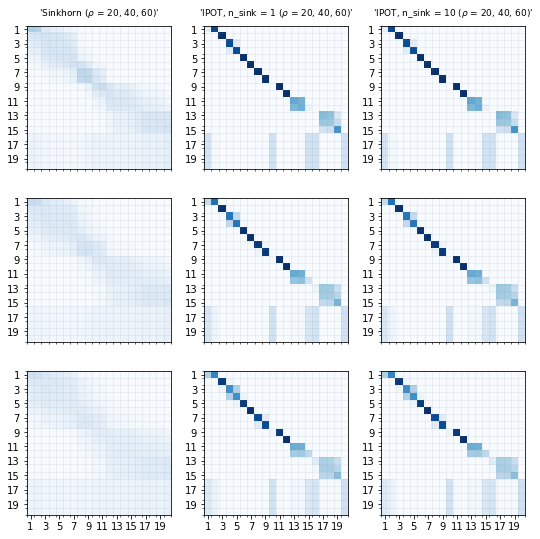

In [ ]:
# define the sequences whose TT-metric we approximate (X has to be the shorter sequence)
X = [1.94,  5.26,  6.12,  6.83,  7.71,  9.68, 11.85, 12.23, 18.57, 20.21, 21.86, 22.66, 25.86, 26.01, 26.43]
Y = [1.25,  1.75,  4.5 ,  5.52,  5.81,  6.75,  7.92, 12.9 , 14.55, 17.02, 17.82, 21.48, 22.67, 22.68, 23.42, 24.74, 26.13, 26.15, 26.33, 28.03]
X_len = 15
Y_len = 20

max_seq_len = max(len(X), len(Y))
max_T = 30
penalty = max_T/2  # penalty for unmatched points in Sinkhorn and IPOT algorithm


# plot transport plan approximations of Sinkhorn distance algorithm and IPOT algorithm
# for different regularization parameters and different number of inner iterations (IPOT algorithm)
main_iters = 200 # number of main iterations in each algorithm
reg_params_list = [20, 40, 60] # regularization parameters in both algorithms
algo_list = [{"algo": "sink", "n_sink": main_iters, "n_ipot": None},
             {"algo": "ipot", "n_sink": 1,          "n_ipot": main_iters},
             {"algo": "ipot", "n_sink": 10,         "n_ipot": main_iters}]

plot_transport_plan_approxs(X, Y, max_T, algo_list=algo_list, reg_params_list=reg_params_list, main_iters=main_iters, size=3)

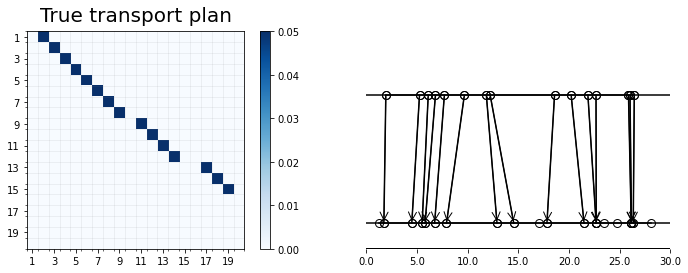

In [ ]:
# plot exact transport plan as given by permutation matrix solution of POA algorithm
# also plot the corresponding assignment of elements from shorter sequence to larger sequence
plot_exact_transport_plan_and_assignment(X, Y, print_assignment=False, size=4)

### Investigate numerical approximation to TT-metric

In the second analysis we approximate the TT-metric by the Sinkhorn distance algorithm and the IPOT algorithm for 100 pairs of sequences and compare the approximation to the exact TT-metric value for each pair in terms of the mean absolute percentage error (MAPE).

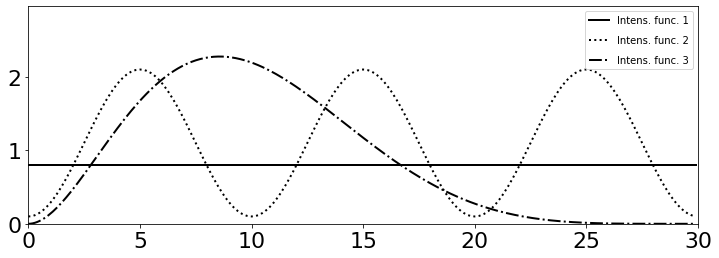

In [ ]:
# create samples from three different inhom. point processes yielding three unique pairings between the samples

max_T = 30

# define and plot intensity functions of three inhom. Poisson processes
x = sy.Symbol("x")
intens_func_1 = 0.8 + 0.000000000000000000001*x    # x has to appear in function expression...
intens_func_2 = 1.1 + sy.sin(sy.pi*(x)/5 - sy.pi/2)
intens_func_3 = 150*(x/30)**2 * (1-(x/30))**5

plot_intens_funcs(list_intens_funcs=[intens_func_1, intens_func_2, intens_func_3], max_T=max_T)

In [ ]:
# calculate MAPE between exact TT-metric values and its approximations by the algorithms
# perform calculation of MAPE for all unique pairs of the samples (each sample pair yielding 100 sequence pairs)
max_T = 30
penalty = max_T/2 # penalty of TT-metric
n_samples = 100

# generate samples
sequences_1 = create_inhom_poisson(func_expr = intens_func_1, n_samples=n_samples, max_T=30)
sequences_2 = create_inhom_poisson(func_expr = intens_func_2, n_samples=n_samples, max_T=30)
sequences_3 = create_inhom_poisson(func_expr = intens_func_3, n_samples=n_samples, max_T=30)

sequences_list = [sequences_1, sequences_2, sequences_3]

# specify algorithms for the TT-metric approximation and a list of regularization parameters
rho_list  = [20, 40, 60]
algo_list = [{"algo": "sink", "n_sink": main_iters, "n_ipot": None,       "reg_params": rho_list},
             {"algo": "ipot", "n_sink": 1,          "n_ipot": main_iters, "reg_params": rho_list},
             {"algo": "ipot", "n_sink": 10,         "n_ipot": main_iters, "reg_params": rho_list}]
iters     = 200 # number of main iterations in algorithms

calculate_MAPEs_between_exact_approx_TT(sequences_list=sequences_list, algo_list=algo_list, iters=500, max_T=max_T, penalty=penalty)

Calculate MAPEs for sequences 1 and 2.
MAPEs with Sinkhorn algorithm (rho = (20, 40, 60)):                          (0.08002, 0.1466, 0.20586)
MAPEs with IPOT algorithm with  1 Sinkhorn iterations (rho = (20, 40, 60)): (0.00025, 0.00061, 0.00103)
MAPEs with IPOT algorithm with 10 Sinkhorn iterations (rho = (20, 40, 60)): (0.00024, 0.00062, 0.00104)


Calculate MAPEs for sequences 1 and 3.
MAPEs with Sinkhorn algorithm (rho = (20, 40, 60)):                         (0.06257, 0.11782, 0.16427)
MAPEs with IPOT algorithm with  1 Sinkhorn iterations (rho = (20, 40, 60)): (0.00032, 0.00043, 0.00067)
MAPEs with IPOT algorithm with 10 Sinkhorn iterations (rho = (20, 40, 60)): (0.00017, 0.00041, 0.00068)


Calculate MAPEs for sequences 2 and 3.
MAPEs with Sinkhorn algorithm (rho = (20, 40, 60)):                         (0.05374, 0.10551, 0.15102)
MAPEs with IPOT algorithm with  1 Sinkhorn iterations (rho = (20, 40, 60)): (0.00043, 0.00041, 0.00064)
MAPEs with IPOT algorithm with 10 Sinkhorn iter